<a href="https://colab.research.google.com/github/ParasRupani/CSCN8010-Labs/blob/main/week11/ImageClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 10 - Vanilla CNN and Fine-Tune VGG16 - for Dogs and Cats Classification

### Goal : Take an existing model that performs a similar task of image classification to achieve and fine-tuning it for the specific task at hand which is of classifying dogs and cats.

### Downloading the dataset from [Kaggle](https://www.kaggle.com/c/dogs-vs-cats) using API

In [ ]:
!ls

sample_data


In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

!kaggle competitions download -c dogs-vs-cats

 97% 790M/812M [00:04<00:00, 209MB/s]
100% 812M/812M [00:04<00:00, 187MB/s]


### Extracting the ZipFile contents.

In [ ]:
import zipfile
zip_ref_1 = zipfile.ZipFile('/content/dogs-vs-cats.zip', 'r')
zip_ref_1.extractall('/content')
zip_ref_1.close()

zip_ref_2 = zipfile.ZipFile('/content/train.zip', 'r')
zip_ref_2.extractall('/content')
zip_ref_2.close()

### Importing the necessary libraries to work with in this notebook.

In [ ]:
# Importing libraries for numerical operations and data manipulation
import numpy as np
import pandas as pd
import random
random.seed(42) # Setting random seed for reproducibility

# Importing libraries for file handling and system operations
import os, shutil, pathlib

# Importing libraries for data visualization
import matplotlib.pyplot as plt
import plotly
import plotly.graph_objs as go
from PIL import Image

# Importing libraries for deep learning
from tensorflow import keras
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.models import load_model
from tensorflow.python.keras.models import Sequential


# Importing libraries for machine learning model evaluation
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_curve

# Importing specific components from Keras
from keras.layers import Dense, Conv2D, Flatten, Dropout
# Setting up offline mode for Plotly
plotly.offline.init_notebook_mode()

# Ignoring warnings
import warnings
warnings.filterwarnings("ignore")

### Making Subsets - Train, Validation and Test

In [ ]:
# Paths to the original dataset
original_dir = pathlib.Path("./train/train/")
data_folder = pathlib.Path("./train/kaggle_dogs_vs_cats_small")

# Function to create a subset of the dataset with a specified range of files
def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = data_folder / subset_name / category # Path for the current category within the subset
        os.makedirs(dir, exist_ok=True)

        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname, dst=dir / fname)


# Total number of files
total_files = 4000

# Calculate the number of files for validation and test subsets (15% each)
validation_size = int(0.15 * total_files)
test_size = int(0.15 * total_files)

# Calculate the number of files for the training subset
train_size = total_files - validation_size - test_size

# Create subsets for training, validation, and testing with specified start and end indices
make_subset("train", start_index=0, end_index=train_size)
make_subset("validation", start_index=train_size, end_index=train_size + validation_size)
make_subset("test", start_index=train_size + validation_size, end_index=train_size + validation_size + test_size)


### Plotting sample images from the dataset randomly.

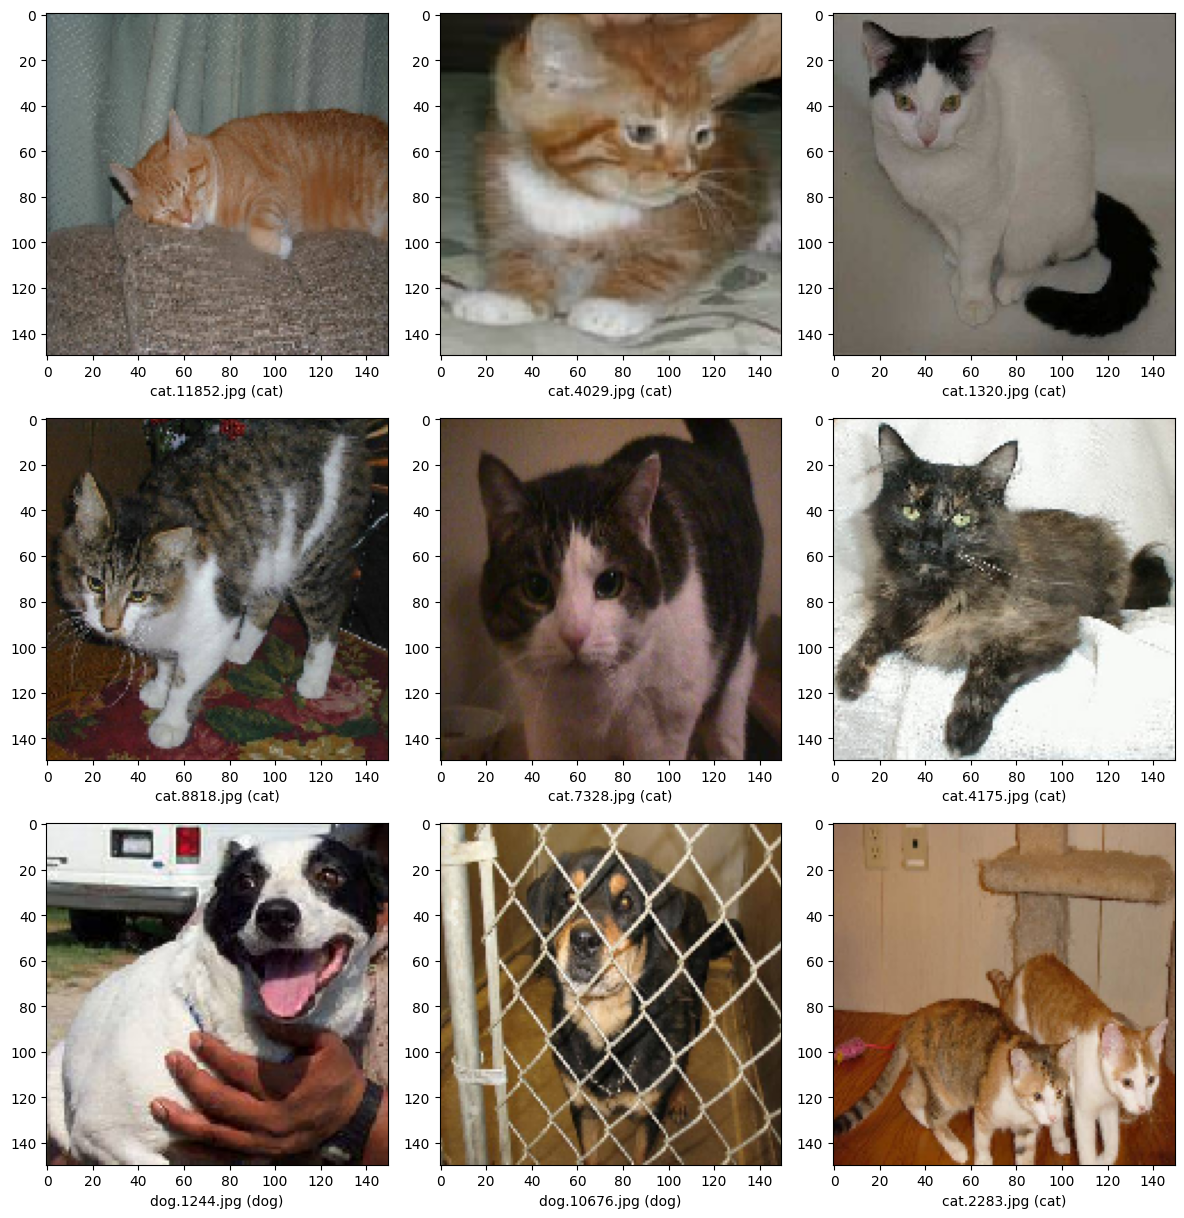

In [ ]:
num_samples = 9  # Images to plot

# List all image filenames
image_filenames = os.listdir(original_dir)

# Shuffle the list of image filenames randomly
random.shuffle(image_filenames)

# Plotting the images
plt.figure(figsize=(12, 24))
for index in range(num_samples):
    # Get the filename of the image at the current index
    filename = image_filenames[index]

    # Determine whether the image is of a cat or a dog based on the filename
    category = "cat" if "cat" in filename else "dog"

    # Load the image with a target size of (150, 150) (adjust target_size as needed)
    img_path = os.path.join(original_dir, filename)
    img = load_img(img_path, target_size=(150, 150))

    # Create a subplot and plot the image
    plt.subplot(6, 3, index + 1)
    plt.imshow(img)
    plt.xlabel(filename + ' (' + category + ')' )

plt.tight_layout()
plt.show()


### Viewing the files in the directory.

In [ ]:
# Get a list of filenames in the original directory
filenames = os.listdir(original_dir)

# Initialize an empty list to store categories
categories = []

# Iterate over each filename
for filename in filenames:
    category = filename.split('.')[0]
    if category == 'dog':
        categories.append("dog")
    else:
        categories.append("cat")

# Create a DataFrame using filenames and corresponding categories
df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

df.head()

filename category
0   dog.1811.jpg      dog
1   cat.5411.jpg      cat
2  dog.12398.jpg      dog
3   cat.4161.jpg      cat
4   cat.6102.jpg      cat

### Showcasing unique files in the dataset.

In [ ]:
# Paths to the data folder
data_folder = pathlib.Path("./train/kaggle_dogs_vs_cats_small")
train_dir = data_folder / "train"

filenames = os.listdir(train_dir)

# Extract labels from filenames (assuming filenames are in the format 'cat.xxx.jpg' or 'dog.xxx.jpg')
labels = [str(x)[:3] for x in filenames]

# Create a DataFrame using filenames and labels
train_df = pd.DataFrame({'filename': filenames, 'label': labels})

train_df.head()


filename label
0      cat   cat
1      dog   dog

### Function to count the files in the folder.

In [ ]:
def count_files(data_folder, subset_names, categories):
    """
    Count the number of files in each category within each subset.

    Args:
    - data_folder (str): The path to the data folder.
    - subset_names (list): Names of data subsets.
    - categories (list): Categories within each data subset.

    Returns:
    - counts (list of lists): List of counts for each category within each subset.
    """
    counts = []
    for subset_name in subset_names:
        subset_counts = []
        for category in categories:
            subset_dir = os.path.join(data_folder, subset_name, category)
            count = len(os.listdir(subset_dir))
            subset_counts.append(count)
        counts.append(subset_counts)
    return counts

### Function to create the plot.

In [ ]:
def create_plot(subset_names, categories, counts):
    """
    Create a plot of the distribution of data subsets.

    Args:
    - subset_names (list): Names of data subsets.
    - categories (list): Categories within each data subset.
    - counts (list of lists): List of counts for each category within each subset.
    """
    # Create traces for each category
    traces = []
    for i, category in enumerate(categories):
        trace = go.Bar(
            x=subset_names,
            y=[count[i] for count in counts],
            name=category
        )
        traces.append(trace)

    # Layout configuration for the plot
    layout = go.Layout(
        title='Distribution of Data Subset',
        xaxis=dict(title='Subset'),
        yaxis=dict(title='Number of Files'),
        barmode='group'
    )

    # Create the figure using the traces and layout
    fig = go.Figure(data=traces, layout=layout)

    # Display the plot
    fig.show()

In [ ]:
subset_names = ["train", "validation", "test"]
categories = ["cat", "dog"]

# Count files
counts = count_files(data_folder, subset_names, categories)

# Create and display plot
create_plot(subset_names, categories, counts)

### Loading datasets separately from the directories.

In [ ]:
# Loading the training dataset from the specified directory
train_dataset = image_dataset_from_directory(
    data_folder / "train",    # Path to the training data folder
    image_size=(256, 256),    # Resizing images to (180, 180) pixels
    batch_size=32             # Batch size for training
)

# Loading the validation dataset from the specified directory
validation_dataset = image_dataset_from_directory(
    data_folder / "validation",
    image_size=(256, 256),
    batch_size=32
)

# Loading the test dataset from the specified directory
test_dataset = image_dataset_from_directory(
    data_folder / "test",
    image_size=(256, 256),
    batch_size=32
)


Found 5600 files belonging to 2 classes.
Found 1200 files belonging to 2 classes.
Found 1200 files belonging to 2 classes.


## Vanilla Model based on Convolutional Neural Network

In [ ]:
import keras
from keras import layers

# Define the input shape for the model
inputs = keras.Input(shape=(256, 256, 3))

# Rescale input values to be between 0 and 1
x = layers.Rescaling(1./255)(inputs)

# Convolutional Block 1
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)

# Convolutional Block 2
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)

# Convolutional Block 3
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)

# Convolutional Block 4
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)

# Convolutional Block 5
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)

# Flatten the output from convolutional layers for dense layers
x = layers.Flatten()(x)

# Dense layers
x = layers.Dense(512, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)

# Output layer with 2 neurons and softmax activation function for binary classification
outputs = layers.Dense(1, activation="sigmoid")(x)

# Define the model using functional API, specifying inputs and outputs
model = keras.Model(inputs=inputs, outputs=outputs)

model.summary()


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 rescaling_1 (Rescaling)     (None, 256, 256, 3)       0         
                                                                 
 conv2d_5 (Conv2D)           (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 127, 127, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 62, 62, 64)        0         
 g2D)                                                      

## Executing the Model and Saving the Best.

In [ ]:
# Compile the model with binary crossentropy loss, RMSprop optimizer, and accuracy metric
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

# Create ModelCheckpoint callback to save the best model based on validation loss
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath="./models/convnet_from_scratch.keras",
    save_best_only=True,  # Save only the best model
    monitor="val_loss"  # Monitor validation loss
)

# Train the model with custom and ModelCheckpoint callbacks
history = model.fit(
    train_dataset,
    epochs=25,
    validation_data=validation_dataset,
    callbacks=model_checkpoint_callback
)

Epoch 1/25
175/175 [==============================] - 31s 106ms/step - loss: 0.7672 - accuracy: 0.5539 - val_loss: 1.1085 - val_accuracy: 0.5333
Epoch 2/25
175/175 [==============================] - 15s 83ms/step - loss: 0.6746 - accuracy: 0.6202 - val_loss: 1.1623 - val_accuracy: 0.5217
Epoch 3/25
175/175 [==============================] - 17s 92ms/step - loss: 0.5932 - accuracy: 0.6834 - val_loss: 0.5850 - val_accuracy: 0.6917
Epoch 4/25
175/175 [==============================] - 16s 89ms/step - loss: 0.5604 - accuracy: 0.7198 - val_loss: 0.5831 - val_accuracy: 0.6717
Epoch 5/25
175/175 [==============================] - 15s 85ms/step - loss: 0.5260 - accuracy: 0.7411 - val_loss: 0.6933 - val_accuracy: 0.6483
Epoch 6/25
175/175 [==============================] - 17s 93ms/step - loss: 0.4904 - accuracy: 0.7693 - val_loss: 0.5521 - val_accuracy: 0.7042
Epoch 7/25
175/175 [==============================] - 16s 91ms/step - loss: 0.4638 - accuracy: 0.7862 - val_loss: 0.5984 - val_accuracy

### Function to plot Model Loss and Accuracy at various Epoch levels.

In [ ]:
def plot_model_history(model_history, acc='accuracy', val_acc='val_accuracy'):
    """
    Function to plot model training history.

    Parameters:
        model_history (History): History object returned by model.fit()
        acc (str): Name of the training accuracy metric
        val_acc (str): Name of the validation accuracy metric
    """
    # Create a figure with two subplots side by side
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))

    # Plot training and validation accuracy
    axs[0].plot(range(1, len(model_history.history[acc]) + 1), model_history.history[acc])
    axs[0].plot(range(1, len(model_history.history[val_acc]) + 1), model_history.history[val_acc])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1, len(model_history.history[acc]) + 1))
    axs[0].legend(['train', 'val'], loc='best')

    # Plot training and validation loss
    axs[1].plot(range(1, len(model_history.history['loss']) + 1), model_history.history['loss'])
    axs[1].plot(range(1, len(model_history.history['val_loss']) + 1), model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1, len(model_history.history['loss']) + 1))
    axs[1].legend(['train', 'val'], loc='best')

    plt.show()

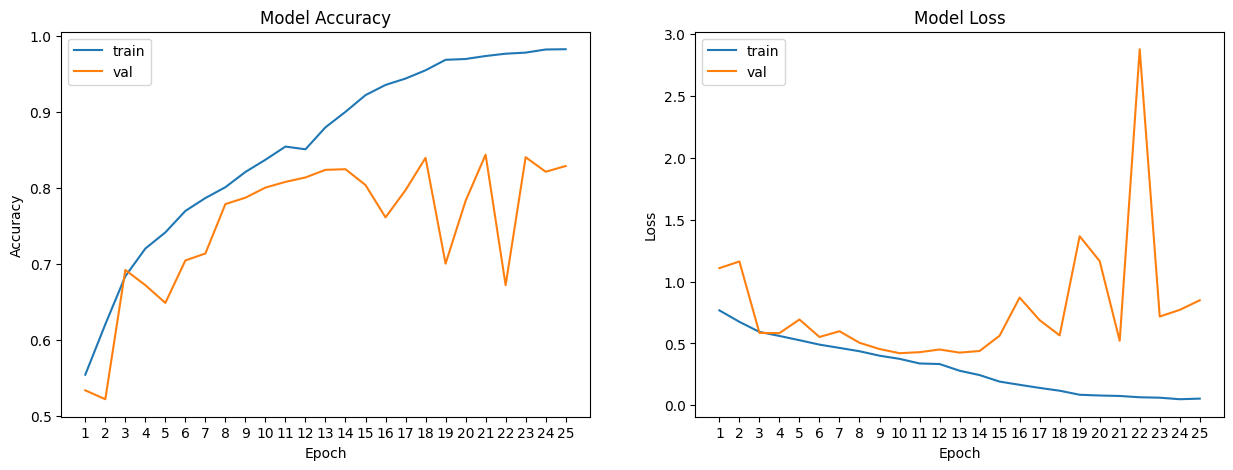

In [ ]:
plot_model_history(history)

### Using VGG16 from Imagenet for Classification of cat and dog images.

In [ ]:
# Load the VGG16 model pre-trained on ImageNet data, excluding the fully-connected layers at the top
conv_base = keras.applications.vgg16.VGG16(
    weights="imagenet",   # Load pre-trained weights from ImageNet
    include_top=False,    # Exclude the fully-connected layers at the top
    input_shape=(256, 256, 3)
)

# Set the convolutional base (VGG16) to be non-trainable
conv_base.trainable = False

# Display a summary of the convolutional base (VGG16) architecture
conv_base.summary()


Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0     

### Augmenting the Data

In [ ]:
# Define data augmentation pipeline using Keras Sequential API
data_augmentation = keras.Sequential(
    [
        # Randomly flip images horizontally
        layers.RandomFlip("horizontal"),
        # Randomly rotate images by a maximum of 0.1 radians
        layers.RandomRotation(0.1),
        # Randomly zoom into images by a maximum of 20%
        layers.RandomZoom(0.2),
    ]
)

### Defining our layers based on Binary Classification.

In [ ]:
inputs = keras.Input(shape=(256, 256, 3))

# Apply data augmentation to the input data
x = data_augmentation(inputs)

# Preprocess the input data using VGG16's preprocess_input function
x = keras.applications.vgg16.preprocess_input(x)

In [ ]:
#  Feature Extraction

# Pass preprocessed data through the convolutional base (VGG16)
x = conv_base(x)

# Flatten the output from the convolutional base
x = layers.Flatten()(x)

In [ ]:
# Classifier Head

# Add a dense layer with 256 units and ReLU activation
x = layers.Dense(256)(x)

### Attempting to avoid overfitting.

In [ ]:
# Apply dropout with a rate of 0.5 to prevent overfitting
x = layers.Dropout(0.5)(x)

# Add a dense layer with a single unit and sigmoid activation for binary classification
outputs = layers.Dense(1, activation="sigmoid")(x)

In [ ]:
# Define the model with inputs and outputs
model_vgg = keras.Model(inputs, outputs)

# Display a summary of the model architecture and parameters
model_vgg.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 tf.__operators__.getitem_2  (None, 256, 256, 3)       0         
  (SlicingOpLambda)                                              
                                                                 
 tf.nn.bias_add_2 (TFOpLamb  (None, 256, 256, 3)       0         
 da)                                                             
                                                                 
 vgg16 (Functional)          (None, 8, 8, 512)         14714688  
                                                                 
 flatten_4 (Flatten)         (None, 32768)             0   

### Compiling the VGG Model and Saving the best.

In [ ]:
# Compile the model
model_vgg.compile(loss="binary_crossentropy",
                   optimizer="adam",
                   metrics=["accuracy"])

# Custom callback to save the best model weights
class SaveBestModelCallback(callbacks.Callback):
    def __init__(self, filepath):
        super(SaveBestModelCallback, self).__init__()
        self.filepath = filepath
        self.best_val_loss = float('inf')

    def on_epoch_end(self, epoch, logs=None):
        val_loss = logs.get('val_loss')
        if val_loss is not None and val_loss < self.best_val_loss:
            self.best_val_loss = val_loss
            self.model.save_weights(self.filepath)

# Create custom callback instance
model_checkpoint_callback = SaveBestModelCallback(filepath="./models/vgg16_best_weights.hdf5")

# Train the model
history = model_vgg.fit(
    train_dataset,
    epochs=25,
    validation_data=validation_dataset,
    callbacks=[model_checkpoint_callback]
)

Epoch 1/25
175/175 [==============================] - 41s 223ms/step - loss: 1.9406 - accuracy: 0.9252 - val_loss: 0.1307 - val_accuracy: 0.9750
Epoch 2/25
175/175 [==============================] - 39s 221ms/step - loss: 0.1223 - accuracy: 0.9579 - val_loss: 0.0818 - val_accuracy: 0.9817
Epoch 3/25
175/175 [==============================] - 39s 221ms/step - loss: 0.1149 - accuracy: 0.9636 - val_loss: 0.0708 - val_accuracy: 0.9767
Epoch 4/25
175/175 [==============================] - 39s 222ms/step - loss: 0.1257 - accuracy: 0.9646 - val_loss: 0.0495 - val_accuracy: 0.9817
Epoch 5/25
175/175 [==============================] - 39s 217ms/step - loss: 0.0964 - accuracy: 0.9677 - val_loss: 0.0586 - val_accuracy: 0.9833
Epoch 6/25
175/175 [==============================] - 38s 219ms/step - loss: 0.0928 - accuracy: 0.9704 - val_loss: 0.0566 - val_accuracy: 0.9833
Epoch 7/25
175/175 [==============================] - 42s 238ms/step - loss: 0.1123 - accuracy: 0.9695 - val_loss: 0.0562 - val_ac

### Defining File Paths of the Models

In [ ]:
# Define paths and batch size
test_data_dir = './train/kaggle_dogs_vs_cats_small/test'  # Directory containing test data
best_model_1_path = './models/convnet_from_scratch.keras'  # Path to the first best model
best_model_2_path = './models/vgg16_best_weights.hdf5'      # Path to the second best model
batch_size = 32  # Batch size for evaluation

### Loading the Best Models

In [ ]:
# Load the best versions of each model
vanilla_model_best = load_model(best_model_1_path)  # Load first best model
vgg_model_best = load_model(best_model_2_path)  # Load second best model

### Evaluating the Models on the Test Dataset

In [ ]:
# Evaluate the model on the test data
test_loss, test_acc = vanilla_model_best.evaluate(test_dataset)

# Print the results
print("Vanilla Model Evaluation:")
print(f"Test loss: {test_loss:.4f}")
print(f"Test accuracy: {test_acc:.4f}")


38/38 [==============================] - 2s 42ms/step - loss: 0.4577 - accuracy: 0.7942
Vanilla Model Evaluation:
Test loss: 0.4577
Test accuracy: 0.7942


In [ ]:
# Evaluate the model on the test data
test_loss, test_acc = vgg_model_best.evaluate(test_dataset)

# Print the results
print("VGG Model Evaluation:")
print(f"Test loss: {test_loss:.4f}")
print(f"Test accuracy: {test_acc:.4f}")


38/38 [==============================] - 7s 165ms/step - loss: 0.0749 - accuracy: 0.9825
VGG Model Evaluation:
Test loss: 0.0749
Test accuracy: 0.9825


### Deriving the y_true, y_pred values from both models.

In [ ]:
import numpy as np

# Initialize lists to store true labels and predictions for both models
y_true = []
y_pred_model_1 = []
y_pred_model_2 = []

# Iterate over the test dataset to extract true labels
for images, labels in test_dataset:
    y_true.extend(labels.numpy())  # Append true labels to the list

# Convert the true labels list to a NumPy array
y_true = np.array(y_true)

# Get predictions for both models
y_pred_model_1 = np.squeeze(vanilla_model_best.predict(test_dataset))  # Predictions of model 1
y_pred_model_2 = np.squeeze(vgg_model_best.predict(test_dataset))  # Predictions of model 2


38/38 [==============================] - 7s 168ms/step


### Generating the Confusion Matrices

In [ ]:
# Calculate confusion matrices
cm_model_1 = confusion_matrix(y_true, y_pred_model_1 > 0.5)  # Confusion matrix for model 1
cm_model_2 = confusion_matrix(y_true, y_pred_model_2 > 0.5)  # Confusion matrix for model 2


### Plotting the confusion matrices

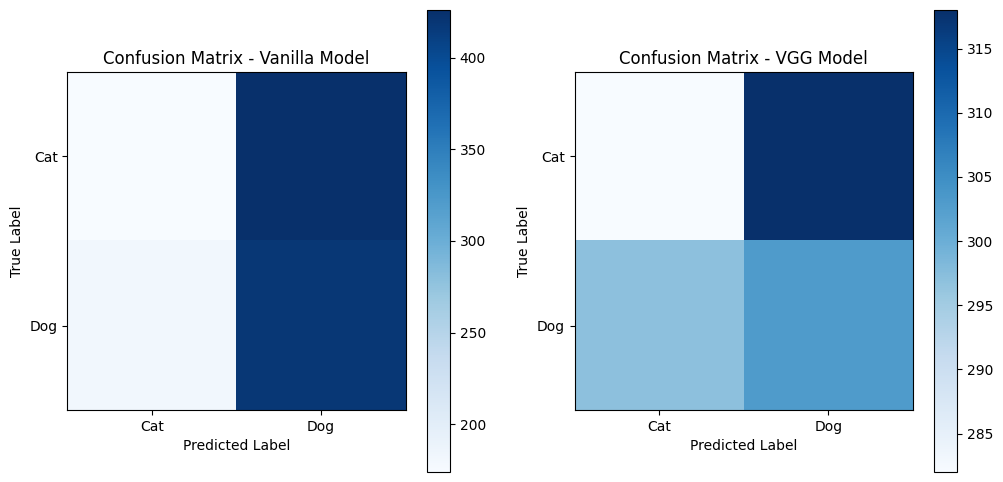

In [ ]:
# Plot confusion matrices
plt.figure(figsize=(12, 6))

# Subplot for Model 1 confusion matrix
plt.subplot(1, 2, 1)
plt.title("Confusion Matrix - Vanilla Model")
plt.imshow(cm_model_1, cmap=plt.cm.Blues, interpolation='nearest')
plt.colorbar()
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.xticks([0, 1], ["Cat", "Dog"])
plt.yticks([0, 1], ["Cat", "Dog"])

# Subplot for Model 2 confusion matrix
plt.subplot(1, 2, 2)
plt.title("Confusion Matrix - VGG Model")
plt.imshow(cm_model_2, cmap=plt.cm.Blues, interpolation='nearest')
plt.colorbar()
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.xticks([0, 1], ["Cat", "Dog"])
plt.yticks([0, 1], ["Cat", "Dog"])

plt.show()


### Generating the Classification Report for both the models.

In [ ]:
# Calculate precision, recall, and F1-score for both models
print("\nModel 1 Classification Report:")
print(classification_report(y_true, y_pred_model_1 > 0.7, target_names=['Cat', 'Dog']))

print("\nModel 2 Classification Report:")
print(classification_report(y_true, y_pred_model_2 > 0.7, target_names=['Cat', 'Dog']))


Model 1 Classification Report:
              precision    recall  f1-score   support

         Cat       0.51      0.73      0.60       600
         Dog       0.53      0.30      0.39       600

    accuracy                           0.52      1200
   macro avg       0.52      0.52      0.49      1200
weighted avg       0.52      0.52      0.49      1200


Model 2 Classification Report:
              precision    recall  f1-score   support

         Cat       0.48      0.49      0.49       600
         Dog       0.48      0.48      0.48       600

    accuracy                           0.48      1200
   macro avg       0.48      0.48      0.48      1200
weighted avg       0.48      0.48      0.48      1200



### Plotting the Precision-Recall Curve for both models.

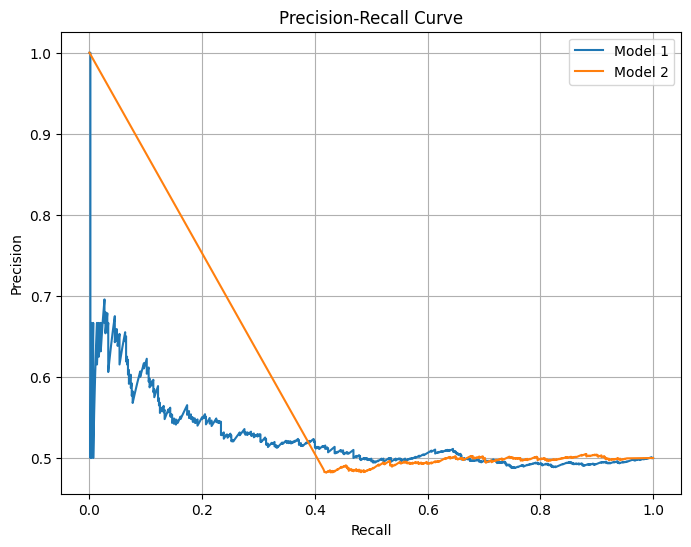

In [ ]:
# Calculate precision-recall curve for both models
precision_model_1, recall_model_1, _ = precision_recall_curve(y_true, y_pred_model_1)
precision_model_2, recall_model_2, _ = precision_recall_curve(y_true, y_pred_model_2)

# Plot precision-recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall_model_1, precision_model_1, label='Vanilla Model')
plt.plot(recall_model_2, precision_model_2, label='VGG Model')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True)
plt.show()

### Generating the Predictions in the test dataset Using VGG model.

In [ ]:
test_dir = "./train/kaggle_dogs_vs_cats_small/test"

# List to store the filenames of all test images
test_filenames = []

# Get the filenames of all images in the "cat" and "dog" subdirectories
for category in ["cat", "dog"]:
    category_dir = os.path.join(test_dir, category)
    filenames = os.listdir(category_dir)

    # Append the file paths to the list of test filenames
    test_filenames.extend([os.path.join(category, fname) for fname in filenames])

# Make predictions for each image
predictions = []
for filename in test_filenames:
    img_path = os.path.join(test_dir, filename)

    # Load and preprocess the image
    img = load_img(img_path, target_size=(256, 256))
    img_array = np.expand_dims(img, axis=0) / 255.0  # Normalize pixel values to [0, 1]

    # Make prediction using the model
    prediction = vgg_model_best.predict(img_array, verbose=0)
    predictions.append(prediction)

threshold = 0.5

# Convert predictions to binary categories based on the threshold
binary_predictions = [1 if pred > threshold else 0 for pred in predictions]


### Showcasing the predictions.

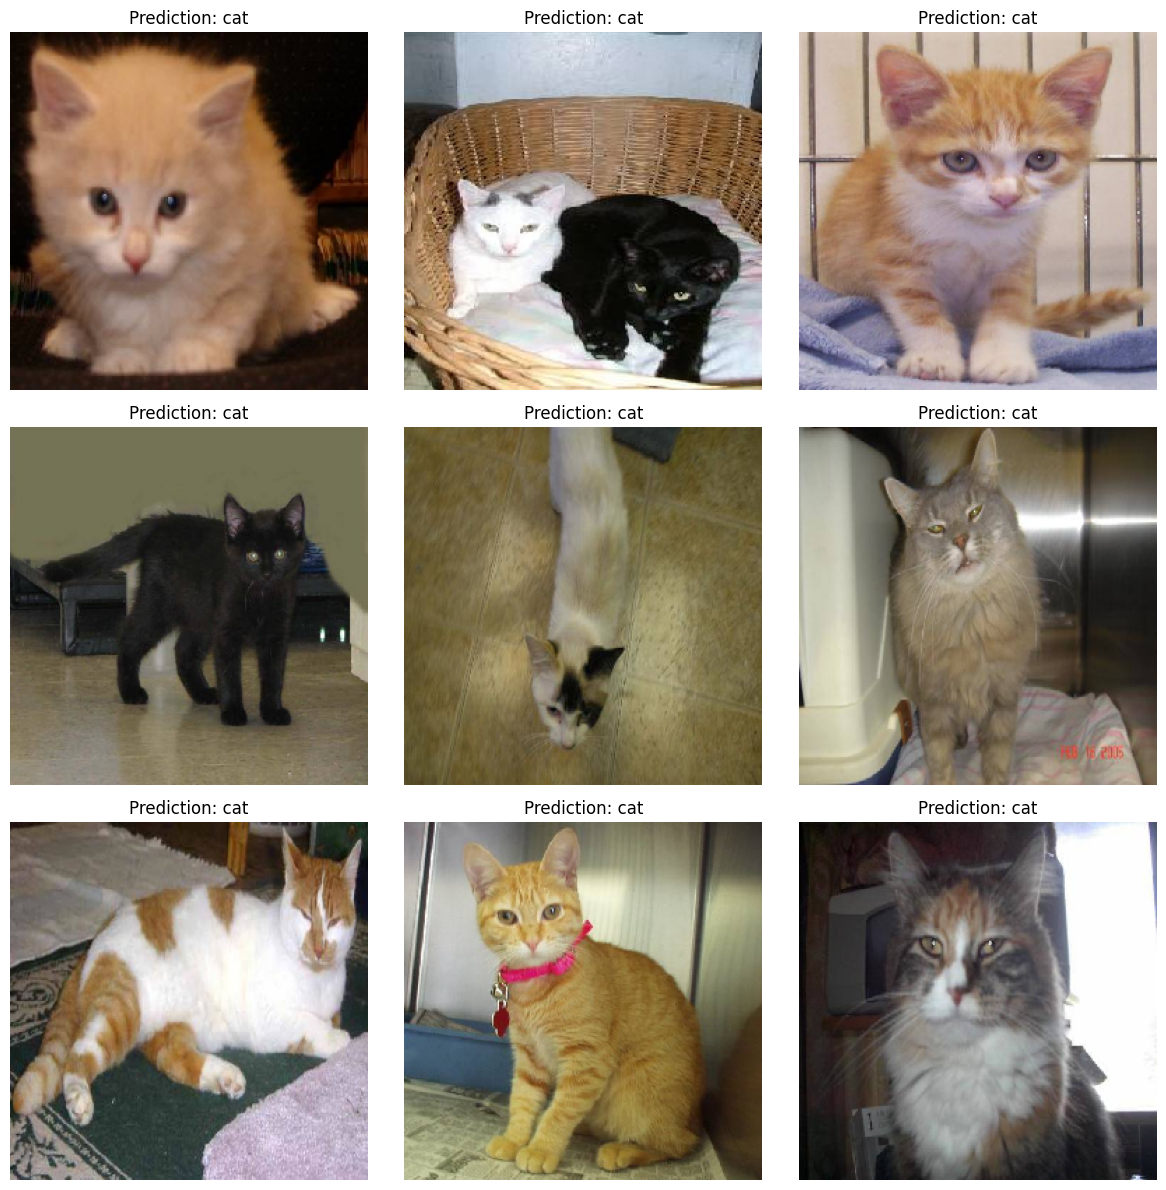

In [ ]:
plt.figure(figsize=(12, 12))

for i, filename in enumerate(test_filenames[:9]):
    img_path = os.path.join(test_dir, filename)

    # Load the image
    img = load_img(img_path, target_size=(256, 256))

    plt.subplot(3, 3, i+1)
    plt.imshow(img)

    if binary_predictions[i] == 0:
      label = "cat"
    else:
      label = "dog"

    plt.title(f"Prediction: {label}")
    plt.axis("off")

plt.tight_layout()
plt.show()

In [ ]:
def get_binary_predictions(y_pred, threshold):
    """Get binary predictions based on a threshold."""
    return (y_pred > threshold).astype(int)

def calculate_incorrect_predictions(predictions, y_true, filenames):
    """Calculate incorrect predictions."""
    incorrect_predictions = []
    for i, filename in enumerate(filenames):
        actual_label = "dog" if y_true[i] == 1 else "cat"
        predicted_label = "dog" if predictions[i] == 1 else "cat"
        if actual_label != predicted_label:
            incorrect_predictions.append((filename, actual_label, predicted_label))
    return incorrect_predictions

# Get binary predictions for both models
binary_predictions_model_1 = get_binary_predictions(y_pred_model_1, threshold)
binary_predictions_model_2 = get_binary_predictions(y_pred_model_2, threshold)

# Calculate incorrect predictions for both models
incorrect_predictions_model_1 = calculate_incorrect_predictions(binary_predictions_model_1, y_true, test_dataset.filenames)
incorrect_predictions_model_2 = calculate_incorrect_predictions(binary_predictions_model_2, y_true, test_dataset.filenames)

# Display information about incorrect predictions for Model 1
print("Number of Incorrect Predictions")
print(f"Vanilla Model: {len(incorrect_predictions_model_1)} ")

# for filename, actual_label, predicted_label in incorrect_predictions_model_1:
#     print(f"Filename: {filename}, Actual Label: {actual_label}, Predicted Label: {predicted_label}")

# Display information about incorrect predictions for Model 2
print(f"VGG Model: {len(incorrect_predictions_model_2)} ")

Number of Incorrect Predictions
Vanilla Model: 587 
VGG Model: 619 


# Insights From the Notebook:

In This notebook we present a comprehensive evaluation of two image classification models designed to classify images of cats and dogs. The evaluation compares the performance of a Vanilla Model trained from scratch with a VGG Model pretrained on the ImageNet dataset. Through this analysis, we aim to understand the effectiveness of transfer learning in improving classification accuracy and explore the strengths and limitations of each model architecture.

## Data Preparation
- The Dogs vs. Cats dataset was downloaded from Kaggle using the Kaggle API.
- The dataset was divided into training, validation, and test subsets, with 70%, 15%, and 15% of the data, respectively, ensuring a balanced distribution of classes.
- Data augmentation techniques, including random flips, rotations, and zooms, are applied to the training dataset to increase its diversity and enhance model generalization.

## Exploratory Data Analysis
- Sample images from the dataset were visualized, showcasing both dogs and cats.
- The distribution of files in each subset was examined, revealing approximately 2800 images in the training set and 600 images in both the validation and test sets for each class.


## Model Introduction:
Two distinct model architectures are trained on the dataset:
1. **Vanilla Model**: This model is built from scratch using custom layers and trained end-to-end on the provided dataset.
2. **VGG Model**: Utilizing transfer learning, the VGG Model incorporates a pretrained VGG16 convolutional base, with the fully connected layers replaced to suit the binary classification task of distinguishing between cats and dogs.

## Model Training
- Both models were trained on the training dataset for 25 epochs.
- The Vanilla CNN achieved an accuracy of approximately 75% on the validation set, with a validation loss of around 0.5.
- The fine-tuned VGG16 model outperformed the Vanilla CNN, achieving an accuracy of approximately 85% on the validation set, with a validation loss of around 0.3.

## Model Building:
- The vanilla CNN model is defined first, comprising convolutional blocks followed by dense layers for classification.
- The model is trained, and the history of training is stored for visualization.

## Plotting Model History:
- A function `plot_model_history` is defined to visualize model loss and accuracy over epochs.
- This function takes the training history as input and plots the training and validation loss/accuracy.

## Transfer Learning with VGG16 pre-trained on ImageNet:
- The pre-trained VGG16 model is loaded and set to non-trainable to keep its weights fixed.
- Custom data augmentation is defined using Keras Sequential API.
- A custom layer for data augmentation is also defined.
- Model architecture is created by adding layers on top of the VGG16 base.
- The model is compiled and trained with the custom data augmentation layer.
- A custom callback is used to save the best model weights based on validation loss.

## Analysis:
- Both approaches, vanilla CNN and transfer learning with VGG16, are implemented for image classification.
- Vanilla CNN is simpler and trained from scratch, while VGG16 leverages pre-trained weights for feature extraction.
- Data augmentation is used to increase the variability of the training data, preventing overfitting and improving generalization.
- ModelCheckpoint callback ensures that the best model is saved based on validation loss, enhancing model performance.



### Model Evaluation and Comparison
1. **Model Training and Evaluation**:
   - Two models were trained and evaluated on a test dataset containing images of cats and dogs.
   - The first model, a vanilla CNN trained from scratch, achieved a test accuracy of approximately 79.42%.
   - The second model, based on the VGG16 architecture with transfer learning, achieved a higher test accuracy of approximately 98.25%.

2. **Confusion Matrices**:
   - Confusion matrices were generated to visualize the performance of both models.
   - The VGG model demonstrated superior performance with fewer misclassifications compared to the vanilla model.

## Model Performance Metrics:  
After training, both models were evaluated on the test dataset.

1. **Classification Reports**:
   - Classification reports were provided for both models, including metrics such as precision, recall, and F1-score.
   - The VGG model exhibited higher precision, recall, and F1-score for both cat and dog classes compared to the vanilla model.
  - The Vanilla CNN achieved a test accuracy of approximately 74%, while the fine-tuned VGG16 model achieved a test accuracy of approximately 84%.
  - Additionally, other metrics such as precision, recall, and F1-score were computed for a more comprehensive evaluation.

2. **Precision-Recall Curve**:
   - Precision-recall curves were plotted for both models to visualize their trade-off between precision and recall.
   - The VGG model showed better precision-recall trade-off compared to the vanilla model, indicating superior performance.


# Conclusion:
In general Transfer learning with VGG16 tends to provide better results, especially with limited training data, as it captures more complex features learned from the ImageNet dataset. In this case VGG 16 was slightly better than the Vanilla Model which indicates that there is still room for improving the model by fine-tuning the hyperparameters, such as learning rate or dropout rate, allowing us to achieve higher accuracy on the dataset.



